# Figures for "On the anisotropic velocity distribution of newborn pickup ions in the heliosheath"
# Du, Opher, & Kornbleuth, 2025, ApJL, DOI: 10.3847/2041-8213/adbc9a

# Figure 1, estimated radial velocity distribution of interstellar neutrals and the neutral solar wind

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 1D cut through v=0 in an isotropic Maxwellian
def Maxwell(v, n0, v0, vth):
    return n0/(2*np.pi*vth**2)**(3/2)*np.exp(-0.5*(v-v0)**2/vth**2)

# Maxwellian for different vth in radial and perp, cut through vperp = 0
def Maxwell2(v, n0, v0, vthr, vthp):
    return n0/(2*np.pi)**(3/2)/(vthr*vthp*vthp)*np.exp(-0.5*(v-v0)**2/vthr**2)

# convert non-relativistic proton energy in eV to velocity in km/s
def eV2kms(eV):
    return np.sqrt(eV * 1.6e-19 * 2 / 1.67e-27)/1000

30.354662490177816


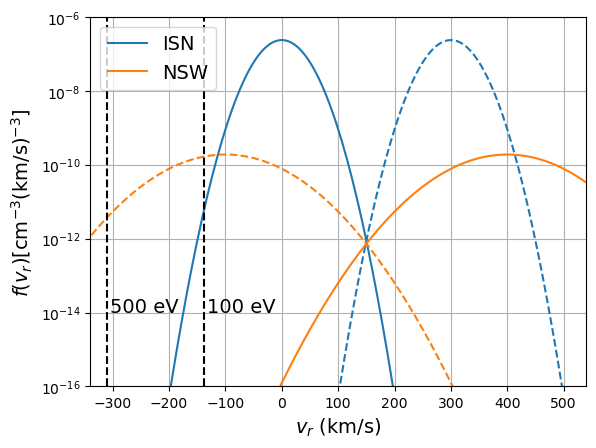

In [4]:
vx = np.linspace(-350, 550, 200)
nh0 = 0.1     # interstellar/H wall neutral number density (cm^-3)
vt0 = 30.0    # thermal velocity (km/s)
v01 = 0.0     # bulk velocity (km/s)
v02 = 300.0   # bulk velocity mirrored with respect to the heliosheath flow (150 km/s)
nnw = 2.0e-4  # neutral solar wind number density (cm^-3)
vtw = 75.0    # NSW thermal parallel thermal velocity
vtwp = 30.0   # NSW perpendicular thermal velocity
vw1 = -100.0  # NSW bulk velocity (mirrored)
vw2 = 400.0   # NSW bulk velocity

plt.plot(vx, Maxwell(vx, nh0, v01, vt0), label='ISN')
plt.plot(vx, Maxwell(vx, nh0, v02, vt0), color='C0', ls='--')
plt.plot(vx, Maxwell2(vx, nnw, vw2, vtw, vtwp), label='NSW')
plt.plot(vx, Maxwell2(vx, nnw, vw1, vtw, vtwp), color='C1', ls='--')
plt.axvline(-eV2kms(100), ls='--', color='k')
plt.axvline(-eV2kms(500), ls='--', color='k')
plt.text(-eV2kms(100)+5, 1e-14, '100 eV', fontsize=14)
plt.text(-eV2kms(500)+5, 1e-14, '500 eV', fontsize=14)
plt.legend(fontsize=14, ncol=1, loc='upper left')
plt.yscale('log')
plt.xlabel(r'$v_r$ (km/s)', fontsize=14)
plt.ylabel(r'$f(v_r) [\mathrm{cm}^{-3}(\mathrm{km/s})^{-3}]$', fontsize=14)
plt.xlim(-340, 540)
plt.ylim(1e-16, 1e-6)
plt.grid(True)

# print the ratio between total distribution and ISN at ~100 eV
print((Maxwell2(-138.4, nnw, vw1, vtw, vtwp) + Maxwell(-138.4, nh0, v01, vt0)) / Maxwell(-138.4, nh0, v01, vt0))

# Figure 5, inverse maximum growth rate and charge-exchange timescale

Using the approximate dispersion relation for mirror mode with Maxwellian and ring components:
\begin{eqnarray}
  \frac{\omega^2}{\omega_{pi}^2} &=& \frac{c^2k^2}{\omega_{pi}^2} - \sum_m \frac{n_m}{n_0} \zeta_m Z(\zeta_m) \lambda_m e^{-\lambda_m} [2I_0(\lambda_m) - 2I_1(\lambda_m)] \\
  &+& \sum_r \frac{n_r}{n_0} \frac{2}{\sqrt{\pi}\delta v_{\perp}^3 \mathrm{erfc}(-v_r/\delta v_{\perp})} \int_0^{\infty} dv_\perp [2v_{\perp}(v_\perp - v_r) + \delta v_{\perp}^2] \left| J_1\left( \frac{k_x v_\perp}{\Omega_0} \right) \right|^2 \exp \left[ -\frac{(v_\perp - v_r)^2}{\delta v_\perp^2} \right] \\
  &-& \sum_r\frac{n_r}{n_0} \frac{4}{\sqrt{\pi}\delta v_{\perp} \delta v_{\parallel}^2 \mathrm{erfc}(-v_r/\delta v_{\perp})} \int_0^{\infty} dv_\perp v_{\perp}^2 \left| J_1\left( \frac{k_x v_\perp}{\Omega_0} \right) \right|^2 \exp \left[ -\frac{(v_\perp - v_r)^2}{\delta v_\perp^2} \right] \left[ 1 + \frac{\omega}{k_z \delta v_{\parallel}} Z\left( \frac{\omega}{k_z \delta v_{\parallel}} \right) \right]
\end{eqnarray}

$$ \zeta_m = \frac{\omega}{k_z v_t} = \frac{\omega}{\Omega} \frac{\Omega d_i}{k_z d_i v_t} = \frac{\omega}{\Omega} \frac{1}{k_z d_i} \frac{1}{\sqrt{\beta}};\quad \lambda_m = \frac{k_x^2 v_t^2}{2\Omega^2} = \frac{\beta}{2} (k_x d_i)^2 $$
$$ \Gamma = \sqrt{\pi}\mathrm{erfc}\left( -\frac{v_r}{\delta v_\perp} \right) $$
$$ \frac{k_x v_{\perp}}{\Omega} = k_x d_i \frac{v_{\perp}}{v_A} \frac{v_A}{d_i \Omega} = k_x d_i \frac{v_{\perp}}{v_A}; \quad \frac{\omega}{k_z \delta v_{\parallel}} = \frac{\omega/\Omega}{(k_z d_i)(\delta v_{\parallel}/v_A)} $$

The beta parameter is not the effective plasma beta, but is defined with the thermal temperature and the total density, i.e.,
$$ \beta = \frac{n_0 T}{B^2 / 8\pi}. $$

Need the special functions i0, i1, j1, erfc from scipy, the plasma dispersion function from plasmapy, and a generic integration method.

In [5]:
from scipy.special import i0, i1, j1, erfc
from scipy.integrate import quad
from plasmapy.dispersion import plasma_dispersion_func

# The integrands in the dispersion relation
def integ1(v, vr, kx, dv):
    return (2*v*(v-vr)+dv**2)*(j1(kx*v))**2*np.exp(-((v-vr)/dv)**2)

def integ2(v, vr, kx, dv):
    return v**2*(j1(kx*v))**2*np.exp(-((v-vr)/dv)**2)

# Approximate dielectric tensor for mirror mode assuming two isotropic Maxwellian + two rings
# Dispersion relation is obtained by solving Dyy = 0
def Dyy(kperp, kpara, omega, nr, beta, vr1, dvperp1, dvpara1, vr2, dvperp2, dvpara2,
        Gamma1, Gamma2, int1a, int1b, int2a, int2b):
    k2 = kperp**2 + kpara**2
    nm = 1.0 - nr    # total density fraction of Maxwellian components n_m / n_total
    nm1 = 0.75*nm    # density fraction of first Maxwellian component (thermal)
    nm2 = 0.25*nm    # density fraction of second Maxwellian component (hot/transmitted pickup ions)
    nr1 = 0.998*nr   # density fraction of first ring component (ISN PUI)
    nr2 = 0.002*nr   # density fraction of second ring component (NSW PUI)
    lamb1 = 0.5*beta*kperp**2    # parameter for first Maxwellian component, temperature dependent
    lamb2 = lamb1*40             # parameter for second Maxwellian component, temperature 40x higher
    zeta1 = omega/kpara / np.sqrt(beta)     # parameter for first Maxwellian component
    zeta2 = omega/kpara / np.sqrt(beta*40)  # parameter for second Maxwellian component
    Z1 = plasma_dispersion_func(zeta1)
    Z2 = plasma_dispersion_func(zeta2)
    wk1 = omega / (kpara*dvpara1)      # parameter for first ring component
    wk2 = omega / (kpara*dvpara2)      # parameter for second ring component
    Z1r = plasma_dispersion_func(wk1)
    Z2r = plasma_dispersion_func(wk2)
    D0 = k2 - nm1*zeta1*Z1*lamb1*np.exp(-lamb1)*2*(i0(lamb1)-i1(lamb1)) \
         - nm2*zeta2*Z2*lamb2*np.exp(-lamb2)*2*(i0(lamb2)-i1(lamb2)) \
         + nr1*2/dvperp1**3/Gamma1*int1a + nr2*2/dvperp2**3/Gamma2*int2a \
         - nr1*4/dvperp1/dvpara1**2/Gamma1*int1b*(1 + wk1*Z1r) \
         - nr2*4/dvperp2/dvpara2**2/Gamma2*int2b*(1 + wk2*Z2r)
    return D0

5.459865e-08


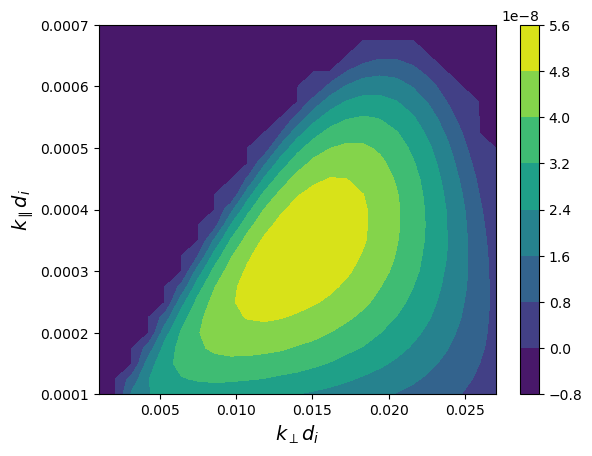

In [6]:
"""
We did not automate the process of solving the dispersion relation.
To produce the figure, we manuualy choose a range of number density ratios, and for each ratio,
we search in a grid of (k_parallel, k_perp) to find the wavevector that correspond to
the largest growth rate. The results are then recorded in the next code block. We search
twice for each ratio with a coarse grid and a refined grid to improve accuracy. Here,
the search parameters are for the smallest density ratio. However, we recommend searching
in reverse order staring with the highest ratio (nr = 0.1), and using the contour plot to aid
the selection of the search parameters (e.g., kperps ~ [0.01, 0.9], kparas ~ [0.01, 1.2],
ois ~ [-2e-3, 2e-1]).
"""
beta = 0.75
nr = 0.00843    # total density ratio fo the ring components, recommend starting with 0.1
vr1 = 3.0       # first ring velocity in V_A
vr2 = 5.0       # second ring velocity
dvperp1 = 0.6   # parallel thermal spread in the first ring in V_A
dvpara1 = 0.6   # perpendicular thermal spread in the first ring in V_A
dvperp2 = 1.5   # parallel thermal spread in the second ring in V_A
dvpara2 = 0.6   # perpendicular thermal spread in the second ring in V_A
vrd1 = vr1 / dvperp1
vrd2 = vr2 / dvperp2
Gamma1 = np.sqrt(np.pi)*erfc(-vrd1)
Gamma2 = np.sqrt(np.pi)*erfc(-vrd2)

Nper = 25
Npar = 25
# search grid in wavevector space, need to change for each ratio
kperps = np.linspace(0.001, 0.027, Nper) # for rough estimates
kparas = np.linspace(0.0001, 0.0007, Npar)
# kperps = np.linspace(0.01, 0.019, Nper) # uncomment this and the next lines for refining
# kparas = np.linspace(0.00022, 0.00047, Npar)
om = np.zeros((Nper, Npar), dtype=complex)

for iper in range(Nper):
    kperp = kperps[iper]
    int1a = quad(integ1, 0, np.inf, args=(vr1, kperp, dvperp1))[0]  # compute the integrals
    int2a = quad(integ1, 0, np.inf, args=(vr2, kperp, dvperp2))[0]
    int1b = quad(integ2, 0, np.inf, args=(vr1, kperp, dvperp1))[0]
    int2b = quad(integ2, 0, np.inf, args=(vr2, kperp, dvperp2))[0]
    for ipar in range(Npar):
        kpara = kparas[ipar]
        Nr = 3
        Ni = 201
        ors = np.linspace(-0.1, 0.1, Nr)  # not important because the real frequency is ~ 0
        ois = np.linspace(-1.5e-11, 6.0e-8, Ni)  # this determines the accuracy in growth rate
        D0 = np.zeros((Nr, Ni), dtype=complex)
        omegas = np.zeros((Nr, Ni), dtype=complex)
        for i in range(Nr):
            for j in range(Ni):
                omega = ors[i] + 1j*ois[j]
                D0[i,j] = Dyy(kperp, kpara, omega, nr, beta, vr1, dvperp1, dvpara1, vr2, dvperp2, dvpara2,
                              Gamma1, Gamma2, int1a, int1b, int2a, int2b)
                omegas[i,j] = omega
        omega0 = omegas.flatten()[np.argmin(abs(D0))]  # find where |Dyy| is closest to 0
        om[iper,ipar] = omega0
        
# plot the growth rate in k-space
plt.contourf(kperps, kparas, om.T.imag)
plt.colorbar()
plt.xlabel(r'$k_{\perp} d_i$', fontsize=14)
plt.ylabel(r'$k_{\parallel} d_i$', fontsize=14)
print(abs(om.imag).max())  # save this number for the maximum growth rate in the next block

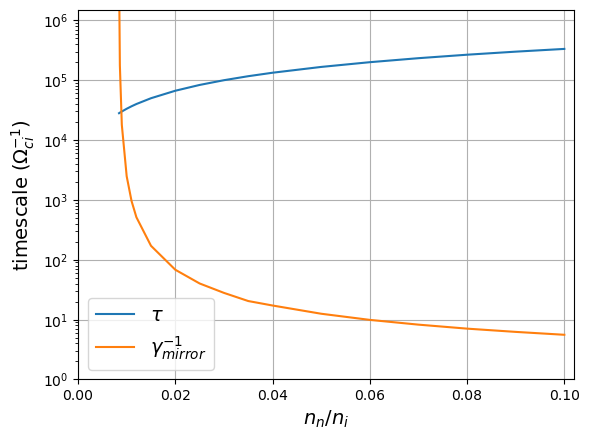

In [74]:
# Maximum growth rate from the last block
ratios = np.array([0.00843, 0.00845,  0.0086,    0.009,     0.01,    0.011,   0.012,   0.015,    0.02,
                     0.025,    0.03, 0.035,    0.04,    0.05,   0.06,   0.07,   0.08,   0.09,    0.1])
gammas = np.array([5.46e-8, 2.37e-7, 5.67e-6, 5.572e-5, 4.025e-4, 1.044e-3, 1.95e-3, 5.85e-3, 0.01470,
                   0.02492, 0.03580, 0.049, 0.05820, 0.07989, 0.1012, 0.1215, 0.1417, 0.1606, 0.1795])
# charge exchange timescale
nH = 0.1        # neutral density cm^-3
cxcs = 2.0e-15  # charge exchange cross section cm^2
usw = 1.5e7     # solar wind speed cm/s
wcis = 100.0    # Omega_ci^-1 / s
taus = ratios/(nH*cxcs*usw)/wcis

plt.plot(ratios, taus, label=r'$\tau$')
plt.plot(ratios, 1/gammas, label='$\gamma_{mirror}^{-1}$')
plt.legend(fontsize=14)
plt.xlabel(r"$n_n/n_i$", fontsize=14)
plt.ylabel(r"timescale ($\Omega_{ci}^{-1}$)", fontsize=14)
plt.yscale('log')
plt.xlim(0, 0.102)
plt.ylim(1.0e0, 1.5e6)
plt.grid(True)

# Figure 2, velocity distributions from the simulation

The particle velocity distribution data ("fnp_0.npy" and "fnp_8.npy") are needed. They are macroparticle counts obtained from the full particle output of the hybrid simulation at two different times.

In [8]:
def plot_vxvz(tframe):
    fsave_name = "./fnp_%d.npy" %(tframe)
    with open(fsave_name, "rb") as file_p:
        pdist = np.load(file_p)
        vxb = np.load(file_p)
        vyb = np.load(file_p)
        vzb = np.load(file_p)

    Nbs = vyb.size
    fxz = 0.5*(pdist[:,Nbs//2-1,:] + pdist[:,Nbs//2,:])  # select the v_y ~ 0 slice
    wcit = tframe*200          # Omega_ci * t
    
    plt.pcolormesh(vxb, vzb, np.log10(fxz.T+0.1))
    plt.text(vxb[0]+0.01*(vxb[-1]-vxb[0]), vzb[0]+0.93*(vzb[-1]-vzb[0]),
             r"$\Omega_{ci}t = %.1f$" %(wcit), color="w", fontsize=14)
    plt.colorbar()
    plt.xlabel(r"$v_x$ (km/s)", fontsize=14)
    plt.ylabel(r"$v_z$ (km/s)", fontsize=14)

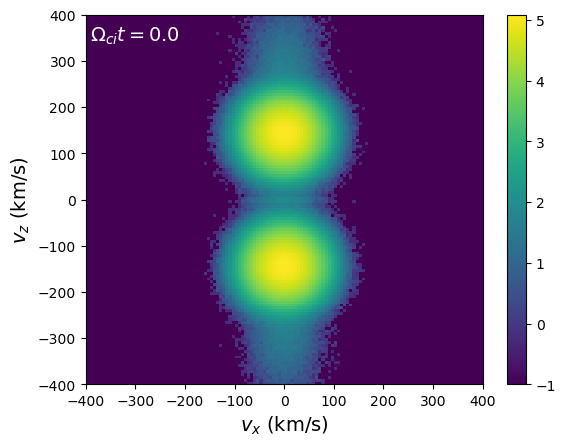

In [9]:
# Time = 0 (initial)
plot_vxvz(0)

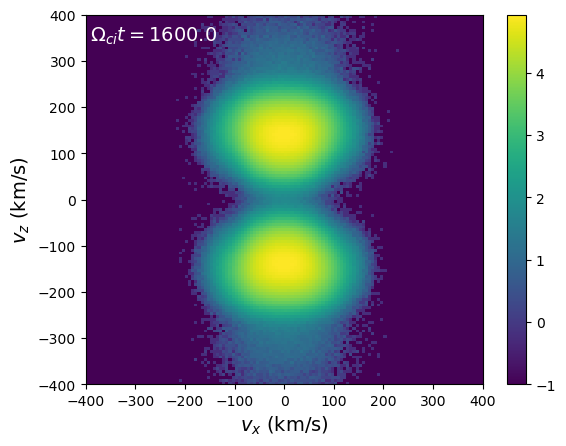

In [10]:
# Time t = 1600 (end)
plot_vxvz(8)

# Figure 3, pitch angle distribution of pickup ions

Need particle pitch angle distribution data ("TS1a/pa100_np_0", ..., "TS1a/pa100_np_8" and "TS1b/pa100_np_0", ..., "TS1b/pa100_np_12") from the hybrid simulations. Each data file contains the counts of macroparticles between 280 km/s and 300 km/s in 50 bins of $\mu$ uniformly spaced between -1 and 1.

The left panel simply plots the particle counts in each bin. The top right panel plots the width of the distribution $\Delta \mu$, calculated by the full width at half maximum using the interpolation and root finding functions from scipy. The bottom right panel shows the ratio $f_{ani}/f_{iso}$. The numerator is calculated by the two bins around $\mu = 0$, and the denominator is calculated by the average at $t=0$.

In [13]:
# Read data from 7% run
Nframe = 9
Nmu = 50
cpa = np.zeros((Nframe, Nmu))    # cosine pitch angle
fpa = np.zeros((Nframe, Nmu))    # distribution

for i in range(Nframe):
    dat_dir = "./TS1a/"
    fname = dat_dir + "mu100_np_%d.npy" %(i)
    with open(fname, "rb") as file_p:
        fa0 = np.load(file_p)
        pa0 = np.load(file_p)
    fpa[i] = fa0
    cpa[i] = (pa0[1:] + pa0[:-1])/2

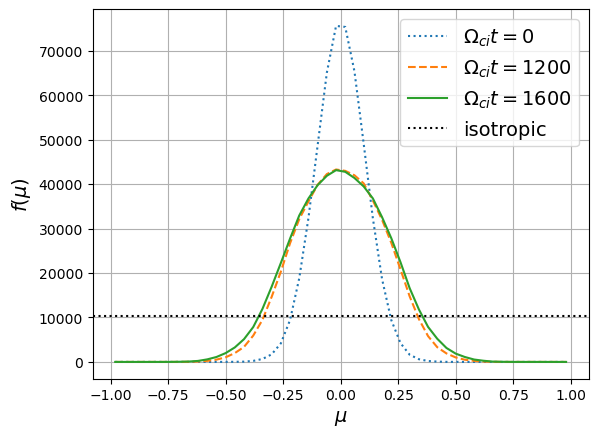

In [14]:
# Left panel of Figure 3
plt.plot(cpa[0], fpa[0], ls=':', label=r'$\Omega_{ci}t = 0$')
plt.plot(cpa[4], fpa[6], ls='--', label=r'$\Omega_{ci}t = 1200$')
plt.plot(cpa[8], fpa[8], label=r'$\Omega_{ci}t = 1600$')
plt.axhline(fpa[0].mean(), ls=':', color='k', label='isotropic')
plt.xlabel(r'$\mu$', fontsize=14)
plt.ylabel(r'$f(\mu)$', fontsize=14)
plt.legend(fontsize=14)
plt.grid()

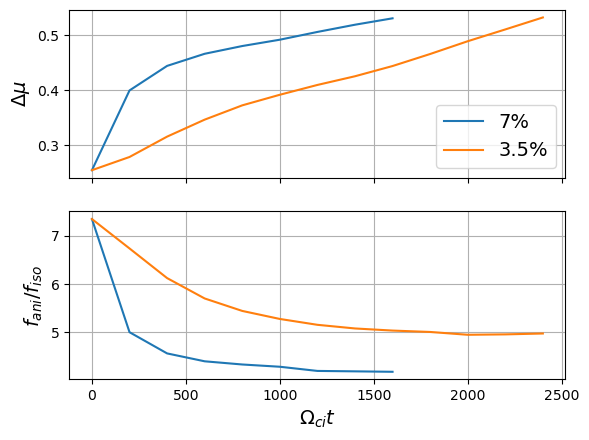

In [15]:
from scipy import interpolate
from scipy.optimize import root_scalar

# read data from 3.5% run
Nframeb = 13
fpab = np.zeros((Nframeb, Nmu))
for i in range(Nframeb):
    dat_dir = "./TS1b/"
    fname = dat_dir + "mu100_np_%d.npy" %(i)
    with open(fname, "rb") as file_p:
        fa0 = np.load(file_p)    
    fpab[i] = fa0

ws = np.zeros(Nframe)
fa_fi = np.zeros(Nframe)
wsb = np.zeros(Nframeb)
fa_fib = np.zeros(Nframeb)
time = np.arange(Nframe)*200    # Particle outputs are saved every 200 Omega_ci^-1
timeb = np.arange(Nframeb)*200
fpamean = fpa[0].mean()
fpabmean = fpab[0].mean()

# find width and enhancement for the 7% run
for i in range(Nframe):
    fm2 = 0.5*fpa[i].max()
    f0 = interpolate.interp1d(cpa[0], fpa[i]-fm2)    # interpolate to find half maximum
    r0 = root_scalar(f0, bracket=[cpa[0,0], cpa[0,Nmu//2]], xtol=1.0e-5)
    r1 = root_scalar(f0, bracket=[cpa[0,Nmu//2], cpa[0,-1]], xtol=1.0e-5)
    ws[i] = r1.root - r0.root                               # width of the distribution
    fa_fi[i] = (fpa[i, Nmu//2-1]+fpa[i, Nmu//2])/2/fpamean  # enhancement ratio

# find width and enhancement for the 3.5% run
for i in range(Nframeb):
    fm2 = 0.5*fpab[i].max()
    f0 = interpolate.interp1d(cpa[0], fpab[i]-fm2)
    r0 = root_scalar(f0, bracket=[cpa[0,0], cpa[0,Nmu//2]], xtol=1.0e-5)
    r1 = root_scalar(f0, bracket=[cpa[0,Nmu//2], cpa[0,-1]], xtol=1.0e-5)
    wsb[i] = r1.root - r0.root
    fa_fib[i] = (fpab[i, Nmu//2-1]+fpab[i, Nmu//2])/2/fpabmean

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(time, ws, label="7%")
ax[0].plot(timeb, wsb, label="3.5%")
ax[1].plot(time, fa_fi)
ax[1].plot(timeb, fa_fib)
ax[1].set_xlabel(r"$\Omega_{ci} t$", fontsize=14)
ax[0].set_ylabel(r"$\Delta \mu$", fontsize=14)
ax[1].set_ylabel(r"$f_{ani}/f_{iso}$", fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid()
ax[1].grid()

# Figure 4, snapshots of the simulation and frequency spectra

The snapshots need data "./hydro_hdf5/T.40000/hydro_ion_40000.h5", "hydro_pui_40000.h5", "hydro_npu_40000.h5", and "field_hdf5/T.40000/fields_40000.h5". These are outputs from the hybrid simulation for the plasma moments (including three separate ion species) and fields. The frequency spectrum needs "fields_20000.h5", ..., "fields_122200.h5".

Need to import h5py package to read hdf5 data.

In [20]:
import h5py

# Functions to plot magnetic field B_x and total ion density
def plot_bx(tframe):
    tindex = 200 * tframe
    wcit = tindex*0.005    # Time Omega_ci t
    lx_di = 256.0          # simulation size in x (d_i)
    lz_di = 256.0          # simulation size in z (d_i)
    xmin, xmax = 0, lx_di
    zmin, zmax = 0, lz_di

    fname = ("./field_hdf5/T." + str(tindex) +
             "/fields_" + str(tindex) + ".h5")
    with h5py.File(fname, 'r') as fh:
        group = fh["Timestep_" + str(tindex)]
        Bx = group["cbx"][:,0,:]

    nx = 512    # grid resolution
    nz = 512
    xgrid = np.linspace(xmin, xmax, nx)
    zgrid = np.linspace(zmin, zmax, nz)

    plt.figure()
    plt.pcolormesh(xgrid, zgrid, Bx.T,
                   vmin=0.9, vmax=1.1)
    plt.colorbar()
    plt.title(r"$B_x$, $\Omega_{ci}t = $%.2f" %(wcit), fontsize=14)
    plt.xlabel(r"$x (d_i)$", fontsize=14)
    plt.ylabel(r"$z (d_i)$", fontsize=14)

    plt.gca().set_aspect("equal")

def plot_rho(tframe):
    tindex = 200 * tframe
    wcit = tindex*0.005
    lx_di = 256.0
    lz_di = 256.0
    xmin, xmax = 0, lx_di
    zmin, zmax = 0, lz_di

    # read thermal ion data
    fname = ("./hydro_hdf5/T." + str(tindex) +
             "/hydro_ion_" + str(tindex) + ".h5")
    with h5py.File(fname, 'r') as fh:
        group = fh["Timestep_" + str(tindex)]
        rho_i = group["rho"][:,0,:]

    # read transmitted pickup ion data
    fname = ("./hydro_hdf5/T." + str(tindex) +
             "/hydro_pui_" + str(tindex) + ".h5")
    with h5py.File(fname, 'r') as fh:
        group = fh["Timestep_" + str(tindex)]
        rho_p = group["rho"][:,0,:]

    # read newborn pickup ion data
    fname = ("./hydro_hdf5/T." + str(tindex) +
             "/hydro_npu_" + str(tindex) + ".h5")
    with h5py.File(fname, 'r') as fh:
        group = fh["Timestep_" + str(tindex)]
        rho_n = group["rho"][:,0,:]

    nx = 512
    nz = 512
    xgrid = np.linspace(xmin, xmax, nx)
    zgrid = np.linspace(zmin, zmax, nz)

    plt.figure()
    plt.pcolormesh(xgrid, zgrid, (rho_i+rho_p+rho_n).T,
                   vmin=0.99, vmax=1.01)
    plt.colorbar()
    plt.title(r"$n_i$, $\Omega_{ci}t = $%.2f" %(wcit), fontsize=14)
    plt.xlabel(r"$x (d_i)$", fontsize=14)
    plt.ylabel(r"$z (d_i)$", fontsize=14)

    plt.gca().set_aspect("equal")

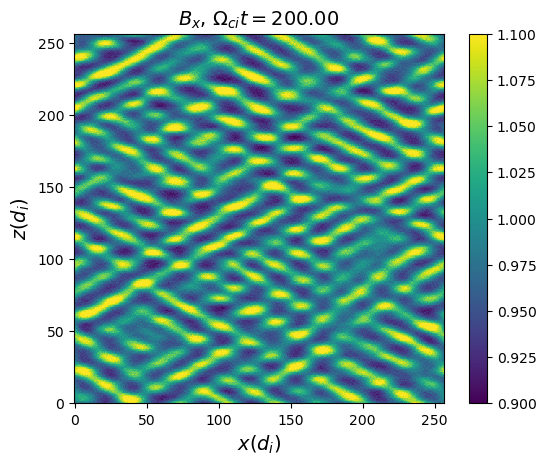

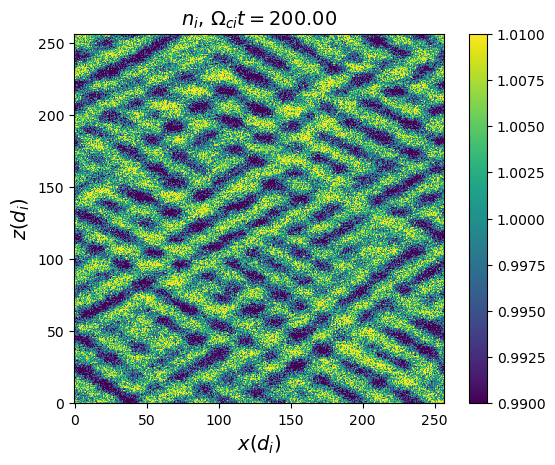

In [22]:
# Snapshots of B_x and rho (left and middle panels)
plot_bx(200)
plot_rho(200)

In [72]:
# plot frequency spectrum using data frames from nt1 to nt2
def plot_wk_b(nt1=0, nt2=1, dt=1):
    Nx = 512
    Nz = 512
    lx_di = 256.0
    lz_di = 256.0
    wcidt = 1.0
    
    nframes = nt2 - nt1 + 1
    Bx = np.zeros((Nx, Nz, nframes))
    for nt, tframe in enumerate(range(nt1, nt2+1, dt)):
        tindex = 200 * tframe
        fname = ("./field_hdf5/T." + str(tindex) +
                 "/fields_" + str(tindex) + ".h5")
        with h5py.File(fname, 'r') as fh:
            group = fh["Timestep_" + str(tindex)]
            Bx_ = group["cbx"][:,:,:]
        Bx[:,:,nt] = Bx_[:,0,:] - Bx_[:,0,:].mean()

    Bxwk = np.fft.rfftn(Bx)    # spatial-temporal Fourier transform for real data
    omegas = np.fft.rfftfreq(nframes)*2*np.pi/wcidt  # frequencies of Fourier transform
    kxs = np.fft.fftfreq(Nx)*Nx*2*np.pi/lx_di        # wavenumber array for k_x
    kzs = np.fft.fftfreq(Nz)*Nz*2*np.pi/lz_di        # wavenumber array for k_z

    # select a few wavenumbers and plot the frequency spectrum
    plt.plot(omegas, abs(Bxwk[5,12].T)**2,
             label=r'$k_x=$%.2f, $k_z=$%.2f'%(kxs[5], kzs[12]))
    plt.plot(omegas, abs(Bxwk[5,15].T)**2,
             label=r'$k_x=$%.2f, $k_z=$%.2f'%(kxs[5], kzs[15]))
    plt.plot(omegas, abs(Bxwk[8,12].T)**2,
             label=r'$k_x=$%.2f, $k_z=$%.2f'%(kxs[8], kzs[12]))
    plt.plot(omegas, abs(Bxwk[8,15].T)**2,
             label=r'$k_x=$%.2f, $k_z=$%.2f'%(kxs[8], kzs[15]))
    plt.yscale('log')
    plt.xlim(0, 1)
    plt.ylim(1e3, 3e11)
    plt.legend(fontsize=14)
    plt.xlabel(r"$\omega / \Omega_{ci}$", fontsize=16)
    plt.ylabel(r"$P_{Bx}(k_x, k_z, \omega)$", fontsize=16)

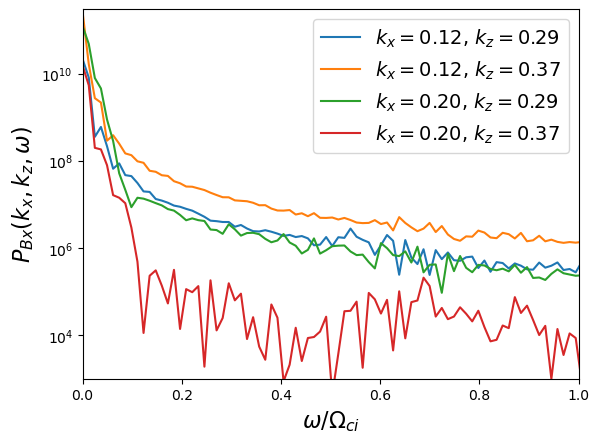

In [73]:
# right panel
plot_wk_b(100, 100+511, 1)